# Randomized Measurements for Multi-param Quantum Metrology

Sisi Zhou, Senrui Chen. arXiv: 2502.03536

use 'qiskit==2.0.0'

**Multiparameter example**: $|\psi_{\bm g}\rangle = \sqrt{1-\sum_ig_i}|\psi_{GHZ}\rangle + \sum_i\sqrt{g_i}X_i|\psi_{GHZ}\rangle$



In [133]:
import numpy as np
from numpy import exp, sqrt, log, pi, cos, sin, abs, mod,arccos
import qiskit
import stim

In [ ]:
import sys
print(sys.executable)

In [135]:
qiskit.__version__


'2.0.0'

## Tune parameters

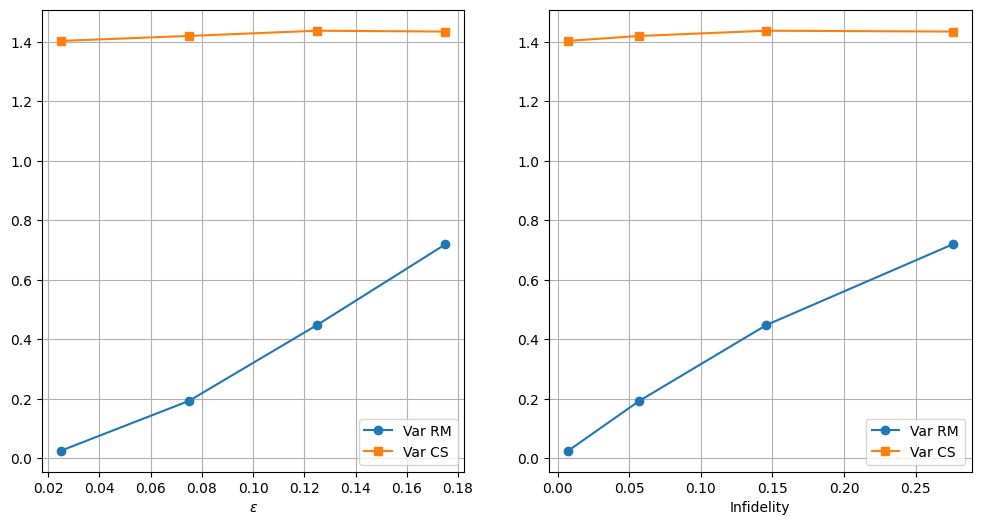

In [158]:
offset = 0.025
g_const = 0.05 + offset
eps = np.array([0.05,0.1,0.15,0.2]) - offset
F = abs(sqrt((1-g_const*3)*(1-g_const*3-3*eps)) + 3* sqrt(g_const*(g_const+eps)) )**2
import matplotlib.pyplot as plt
# plt.plot(eps,F)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,6))


axs[0].plot(eps,(4 *(8+1)/(8+2) * F*(1-F)),'-o',label="Var RM")
axs[0].plot(eps,(2 *(8+1)*(1+2*F)/(8+2) - (1+F)**2),'-s',label="Var CS")
axs[0].set_xlabel(r"$\varepsilon$")
axs[0].legend()
axs[0].grid()


axs[1].plot(1-F,(4 *(8+1)/(8+2) * F*(1-F)),'-o',label="Var RM")
axs[1].plot(1-F,(2 *(8+1)*(1+2*F)/(8+2) - (1+F)**2),'-s',label="Var CS")
axs[1].set_xlabel(r"Infidelity")
axs[1].legend()
axs[1].grid()

## Problem setup

In [137]:
# from qiskit import Statevector
from qiskit.quantum_info import Statevector
n = 3
X = np.matrix([[0,1],[1,0]])
I = np.matrix([[1,0],[0,1]])
Xlist = []
vec0n = np.matrix([1]+[0]*((1<<n)-1)).T
vec1n = np.matrix([0]*((1<<n)-1) + [1]).T
vec_ghz = (vec0n + vec1n)/sqrt(2)
vec_ghzp = []
for i in range(n):
    mat_tmp = np.matrix([[1]])
    for j in range(i):
        mat_tmp = np.kron(I,mat_tmp)
    mat_tmp = np.kron(X,mat_tmp)
    for j in range(i+1,n):
        mat_tmp = np.kron(I,mat_tmp)
    # print(i)
    # print(mat_tmp)
    Xlist.append(mat_tmp)
    vec_ghzp.append(mat_tmp @ vec_ghz)


In [141]:
### Define reference state
g_r = [g_const] * 3
vec_r = sqrt(1 - sum(g_r)) * vec_ghz + sum([sqrt(g_r[i]) * vec_ghzp[i]  for i in range(n)])
psi_r = Statevector(vec_r)

### Define ground truth
eps_list = [0.05,0.10,0.15,0.20]
g_t = dict()
fid_t = dict()
for eps in eps_list:
    g_t[eps] = [g_const + eps] * 3
    vec_t = sqrt(1 - sum(g_t[eps])) * vec_ghz + sum([sqrt(g_t[eps][i]) * vec_ghzp[i]  for i in range(n)])
    psi_t = Statevector(vec_t)
    f = abs(vec_t.H @ vec_r).item()**2
    fid_t[eps] = f

print("eps : true fidelity")
print(fid_t)

eps : true fidelity
{0.05: 0.9672613634390712, 0.1: 0.8902815784698102, 0.15: 0.7798571136907176, 0.2: 0.6342329219213243}


## Data acquisition


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Clifford
from qiskit.quantum_info import random_clifford
from qiskit_aer import AerSimulator
import numpy as np

# ==== Parameter definitions ====
n = 3          # Number of qubits (you can customize this)
Nu = 100000         # Number of random Clifford gates
Ns = 10000      # Number of measurement shots per experiment


for eps in eps_list:
    # save_label = "250518_" + f"{eps:.{2}f}".removeprefix("0.") 
    save_label = "250519_" + f"{eps:.{2}f}".removeprefix("0.")  + "_" + str(Nu//1000)
    g_true = g_t[eps]
    vec_t = sqrt(1 - sum(g_true)) * vec_ghz + sum([sqrt(g_true[i]) * vec_ghzp[i]  for i in range(n)])
    psi_t = Statevector(vec_t)
    f = abs(vec_t.H @ vec_r).item()**2
    print("eps =",eps,"True infidelity =", round(1-f,6))

    # ==== Initialize pure state ====
    init_circuit = QuantumCircuit(n)
    init_circuit.initialize(psi_t)

    # ==== Setup simulator ====
    simulator = AerSimulator(method="density_matrix")

    # ==== Apply random Clifford gates and measure ====
    all_counts = []
    all_cliff = []

    for _ in range(Nu):
        # Generate a random Clifford gate
        cliff = random_clifford(n)

        # Construct the full circuit
        qc = QuantumCircuit(n)
        qc.append(init_circuit, range(n))        # Prepare the custom pure state
        qc.append(cliff.to_circuit(), range(n))  # Apply Clifford gate
        # print(qc)
        qc.measure_all()

        # Transpile and run
        transpiled_qc = transpile(qc, simulator)
        result = simulator.run(transpiled_qc, shots=Ns).result()
        counts = result.get_counts()

        all_counts.append(counts)
        all_cliff.append(cliff.to_dict())

        if(mod(_+1,5000)==0): print(_+1, "/", Nu,"Completed")

    # # ==== Print results ====
    # for i, count in enumerate(all_counts):
    #     print(f"Clifford {i+1}:")
    #     print(count)
    #     print("-----")
        
    ## Data saving
    with open("all_counts_"+save_label+".txt", "w", encoding="utf-8") as file:
        file.write(str(all_counts))
    with open("all_cliff_"+save_label+".txt", "w", encoding="utf-8") as file:
        file.write(str(all_cliff))
